<h1>Testing the E2E simulations</h1>

This script introduces the end-to-end (E2E) simulations that are used in "calibration.py", for the influence calibration of each individual segment. The testing of the script itself is done in teh next notebook.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import webbpsf

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util
import image_pastis as impastis

# Path to all the outputs from "aperture_definition.py".
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
# Change into that directory
os.chdir(dir)

os.environ['WEBBPSF_PATH'] = CONFIG_INI.get('local', 'webbpsf_data_path')

In [2]:
# Get some parameters
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')         # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')                       # filter
im_size = CONFIG_INI.getint('numerical', 'im_size_px')          # image size in pixels

For starters, lets completely independently create some WebbPSF images of a direct image (no coronagraph) and a coronagraphic image.

In [3]:
# Create two NIRCam objects
nc = webbpsf.NIRCam()
nc_coro = webbpsf.NIRCam()

In [4]:
# Btw:
print('NIRCam pixelscale:', nc.pixelscale)
print('Telescope:', nc.telescope)
print('nc name:', nc.name)
print('NIRCam module used:', nc.module)
print('NIRCam list of image masks:', nc.image_mask_list)
print('NIRCam list of pupil masks:', nc.pupil_mask_list)
print('NIRCam currently used OPD:', nc.pupilopd)
print('NIRCam detector list:', nc.detector_list)
print('nc used detector:', nc.detector)
print('Pixel position in (X, Y) on the detector:', nc.detector_position)
print('NIRCam filter list:', nc.filter_list)
print('nc used filter:', nc.filter)
print('nc channel used:', nc.channel)


NIRCam pixelscale: 0.0311
Telescope: JWST
nc name: NIRCam
NIRCam module used: A
NIRCam list of image masks: ['MASKLWB', 'MASKSWB', 'MASK210R', 'MASK335R', 'MASK430R']
NIRCam list of pupil masks: ['CIRCLYOT', 'WEDGELYOT', 'MASKRND', 'MASKSWB', 'MASKLWB', 'WEAK LENS +4', 'WEAK LENS +8', 'WEAK LENS -8', 'WEAK LENS +12 (=4+8)', 'WEAK LENS -4 (=4-8)', 'WLP4', 'WLM4', 'WLP8', 'WLM8', 'WLP12']
NIRCam currently used OPD: OPD_RevW_ote_for_NIRCam_requirements.fits.gz
NIRCam detector list: ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCA5', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4', 'NRCB5']
nc used detector: NRCA1
Pixel position in (X, Y) on the detector: (1024, 1024)
NIRCam filter list: ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']
nc used filter: F200W
nc channel used: short


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


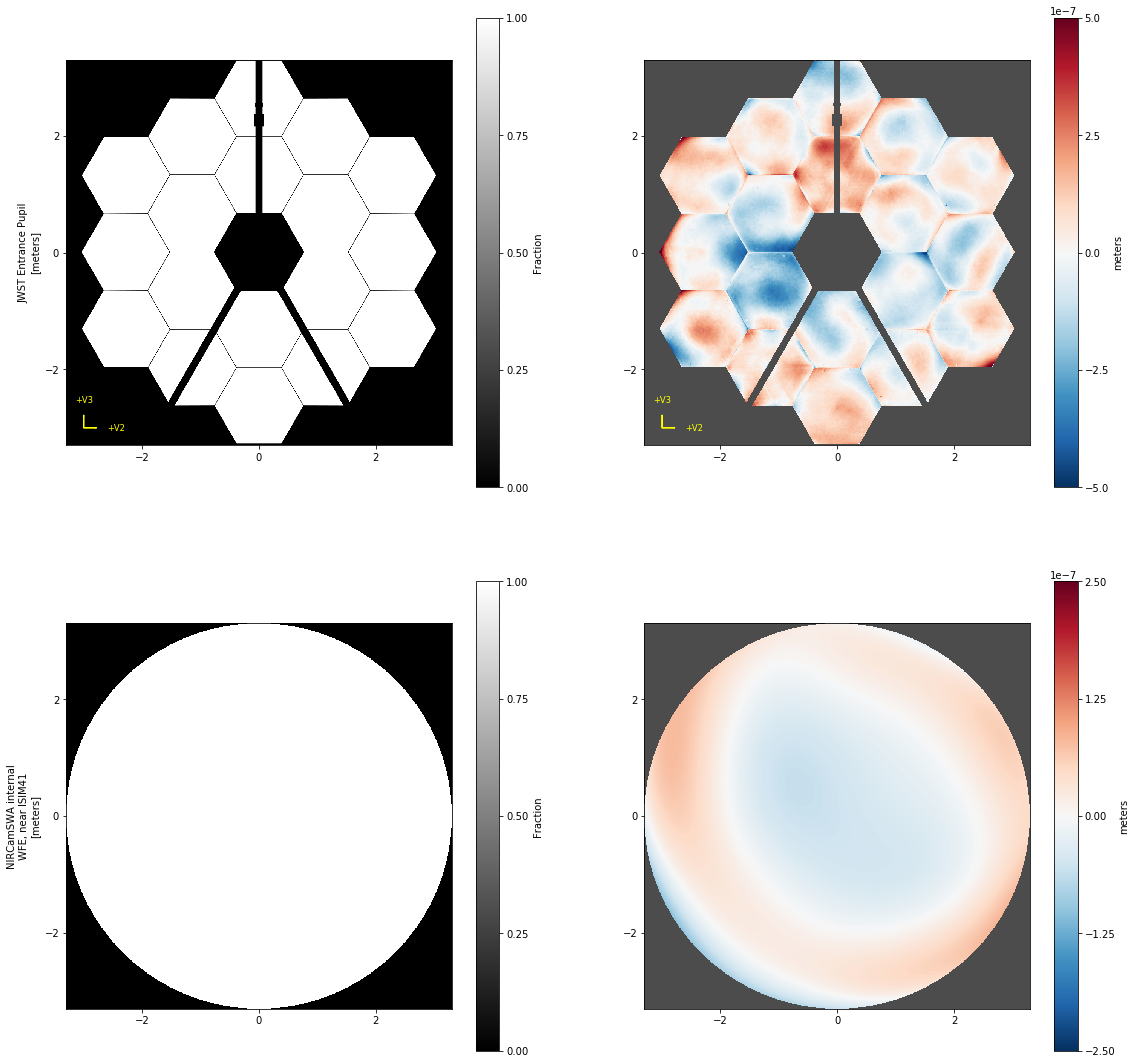

In [5]:
# Some displays
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

#nc.calc_psf?
#nc.calcPSF?

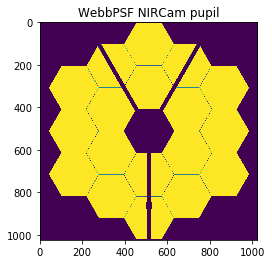

Pupil shape: (1024, 1024)


In [6]:
# Show the pupil used
nc_pup = fits.getdata(nc.pupil)
plt.imshow(nc_pup)
plt.title('WebbPSF NIRCam pupil')
plt.show()

print('Pupil shape:', nc_pup.shape)

In [7]:
# Null the OTE OPDs for the PSFs, internal WFE stays though.
nc, ote = webbpsf.enable_adjustable_ote(nc)                     # create OTE for default PSF
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote.zero()          # set OTE for direct PSF to zero
ote_coro.zero()     # set OTE for coronagraph to zero

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


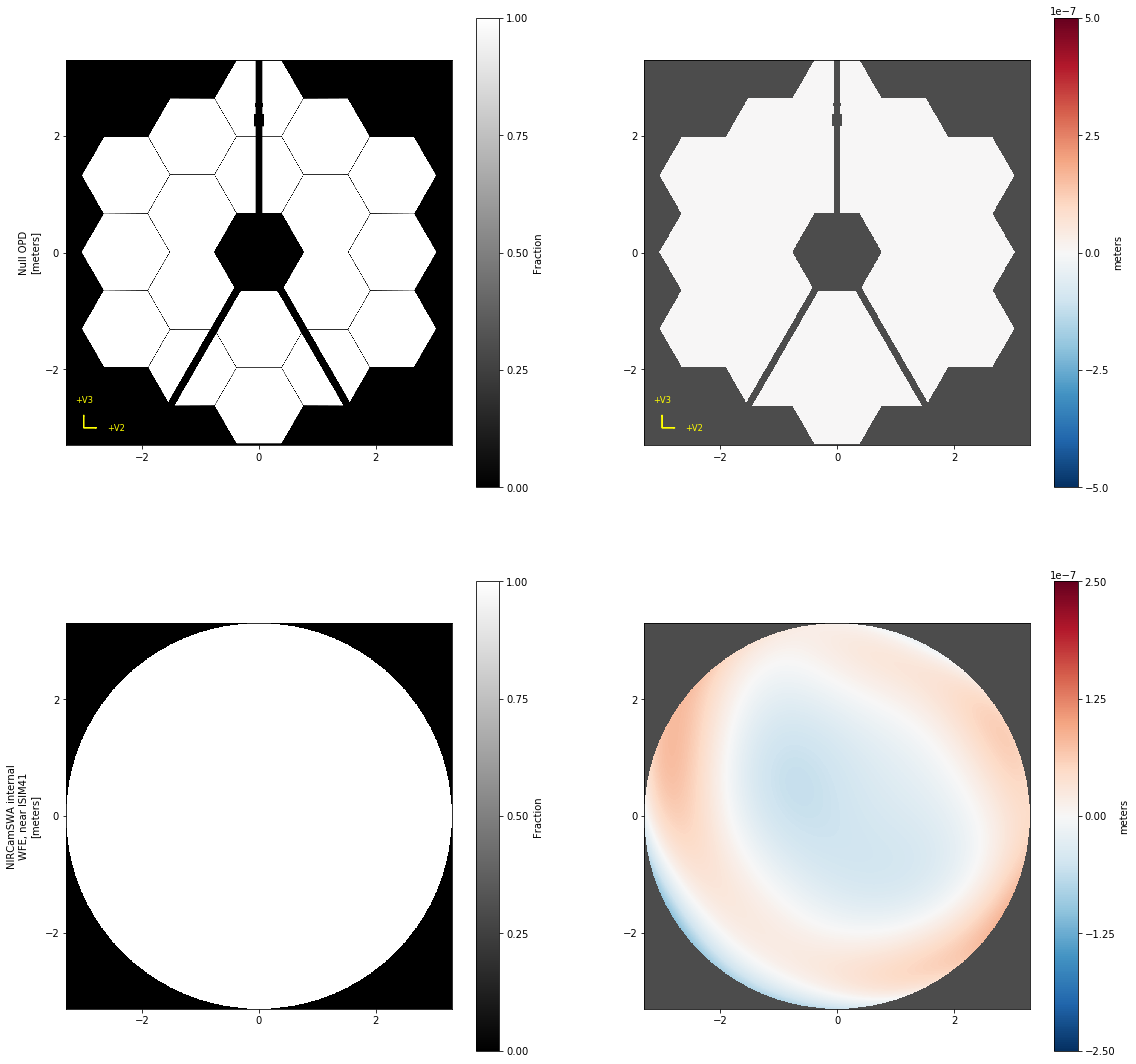

In [8]:
plt.figure(figsize=(19, 19))
nc.display()
plt.show()

From the WebbPSF turotial (https://github.com/mperrin/webbpsf/blob/master/notebooks/WebbPSF_tutorial.ipynb) we know that calc_psf() calculates images with different sampling (I think I also explain this in my notebook "DealingWithWebbPSF.ipynb".) and we can access them in the different HDU extensions.

In that same notebook, I also explain why I use oversample=1 and nlambda=1 to make the calculations faster.

In [9]:
# Let's see what the current direct PSF look like (coronagraphic PSF is the same since they've been set up the same)
psf_direct_hdu = nc.calc_psf(oversample=1, nlambda=1)

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


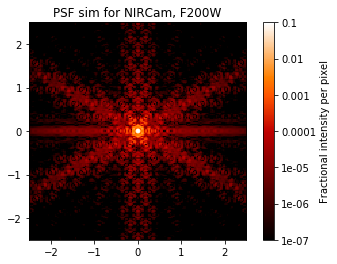

In [10]:
# Display by WebbPSF
webbpsf.display_psf(psf_direct_hdu)
plt.show()

PSF shape: (161, 161)


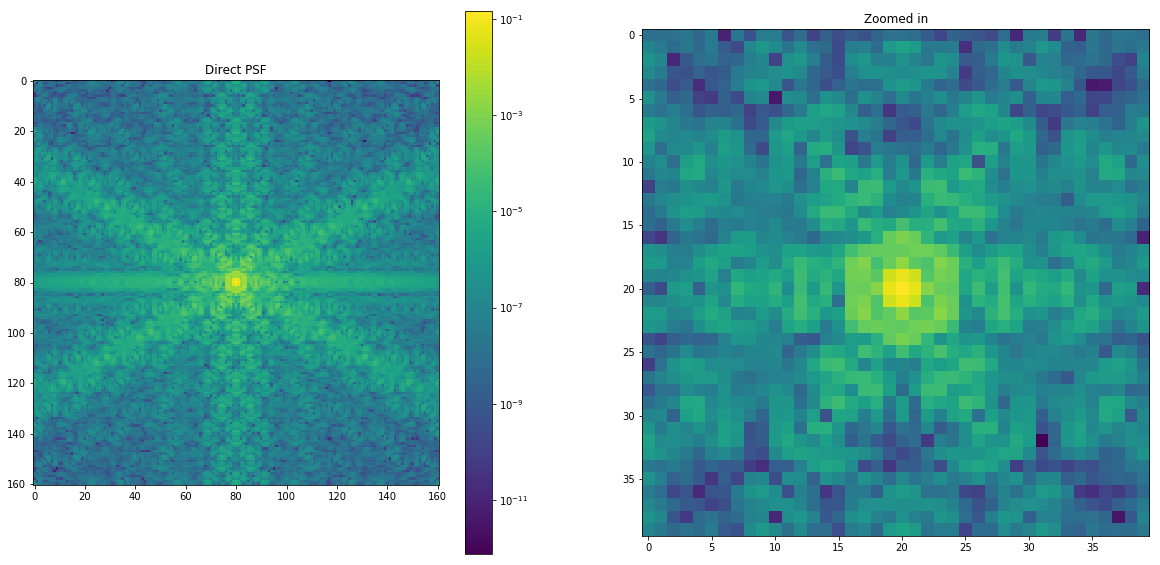

In [11]:
# Display with matplotlib
psf_direct = psf_direct_hdu[1].data
print('PSF shape:', psf_direct.shape)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(psf_direct, norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_direct[60:100, 60:100], norm=LogNorm())
plt.title('Zoomed in')
plt.show()

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


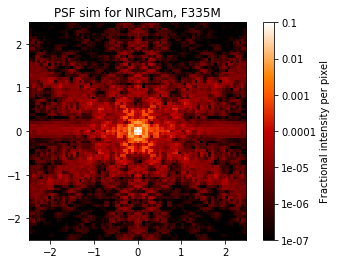

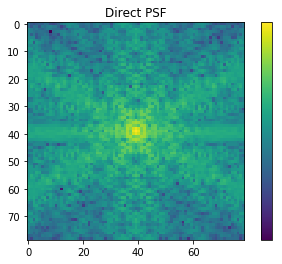

In [12]:
# Add the filter we want to use
nc.filter = filter
nc_coro.filter = filter

# So far both nc objects are still the same, so I'll display only one
psf = nc.calc_psf(oversample=1, nlambda=1)
webbpsf.display_psf(psf)
plt.show()

psf = psf[1].data
plt.imshow(psf, norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.show()

We want our images to be the same size like our simulations, so we use "fov_pixels".

In [ ]:
# Both nc objects are still the same, so I'll display only one
psf = nc.calc_psf(fov_pixels=im_size, oversample=1, nlambda=1)
webbpsf.display_psf(psf)
plt.show()

psf = psf[1].data

In [15]:
# Display with matplotlib
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(psf, norm=LogNorm())
plt.title('Direct PSF')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf[485:540, 485:540], norm=LogNorm())
plt.title('Direct PSF - zoomed in')
plt.show()

TypeError: Image data can not convert to float

In [ ]:
# Now add the coronagraph to nc_coro
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# And show what that looks like
psf_coro = nc_coro.calc_psf(fov_pixels=im_size, oversample=1, nlambda=1, display=True)
plt.show()
psf_coro_im = psf_coro[1].data

print('PSF calculation done')

In [ ]:
# I can't use webbpsf.display_psf(psf_coro) because I couldn't figure out how to change the color scaling
# and it turns out all black. So I'll just use matplotlib.
plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.imshow(psf_coro_im[425:600, 425:600], norm=LogNorm())
plt.title('Coronagraphic PSF - zoomed in')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(psf_coro_im, norm=LogNorm())
plt.title('Coronagraphic PSF')
plt.show()

In [ ]:
# For comparison, the webbpsf display in physical units for the fov:
plt.figure(figsize=(10, 10))
webbpsf.display_psf(psf_coro, vmin=1e-19)
plt.show()

You can see that the coronagraphic PSF is no centro-symmetric, but it does have one symmetry axis. This is because of the weird symmetry of the lyot stop, which you can see above.